In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input 
import tensorflow as tf
from keras.optimizers import SGD
from keras import regularizers
from keras import optimizers

import time

In [3]:
df_store = pd.read_csv('stores.csv') #store data
df_train = pd.read_csv('train.csv') # train set
df_features = pd.read_csv('features.csv') #external information

In [5]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [5]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [6]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [11]:
df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [12]:
df.shape

(421570, 16)

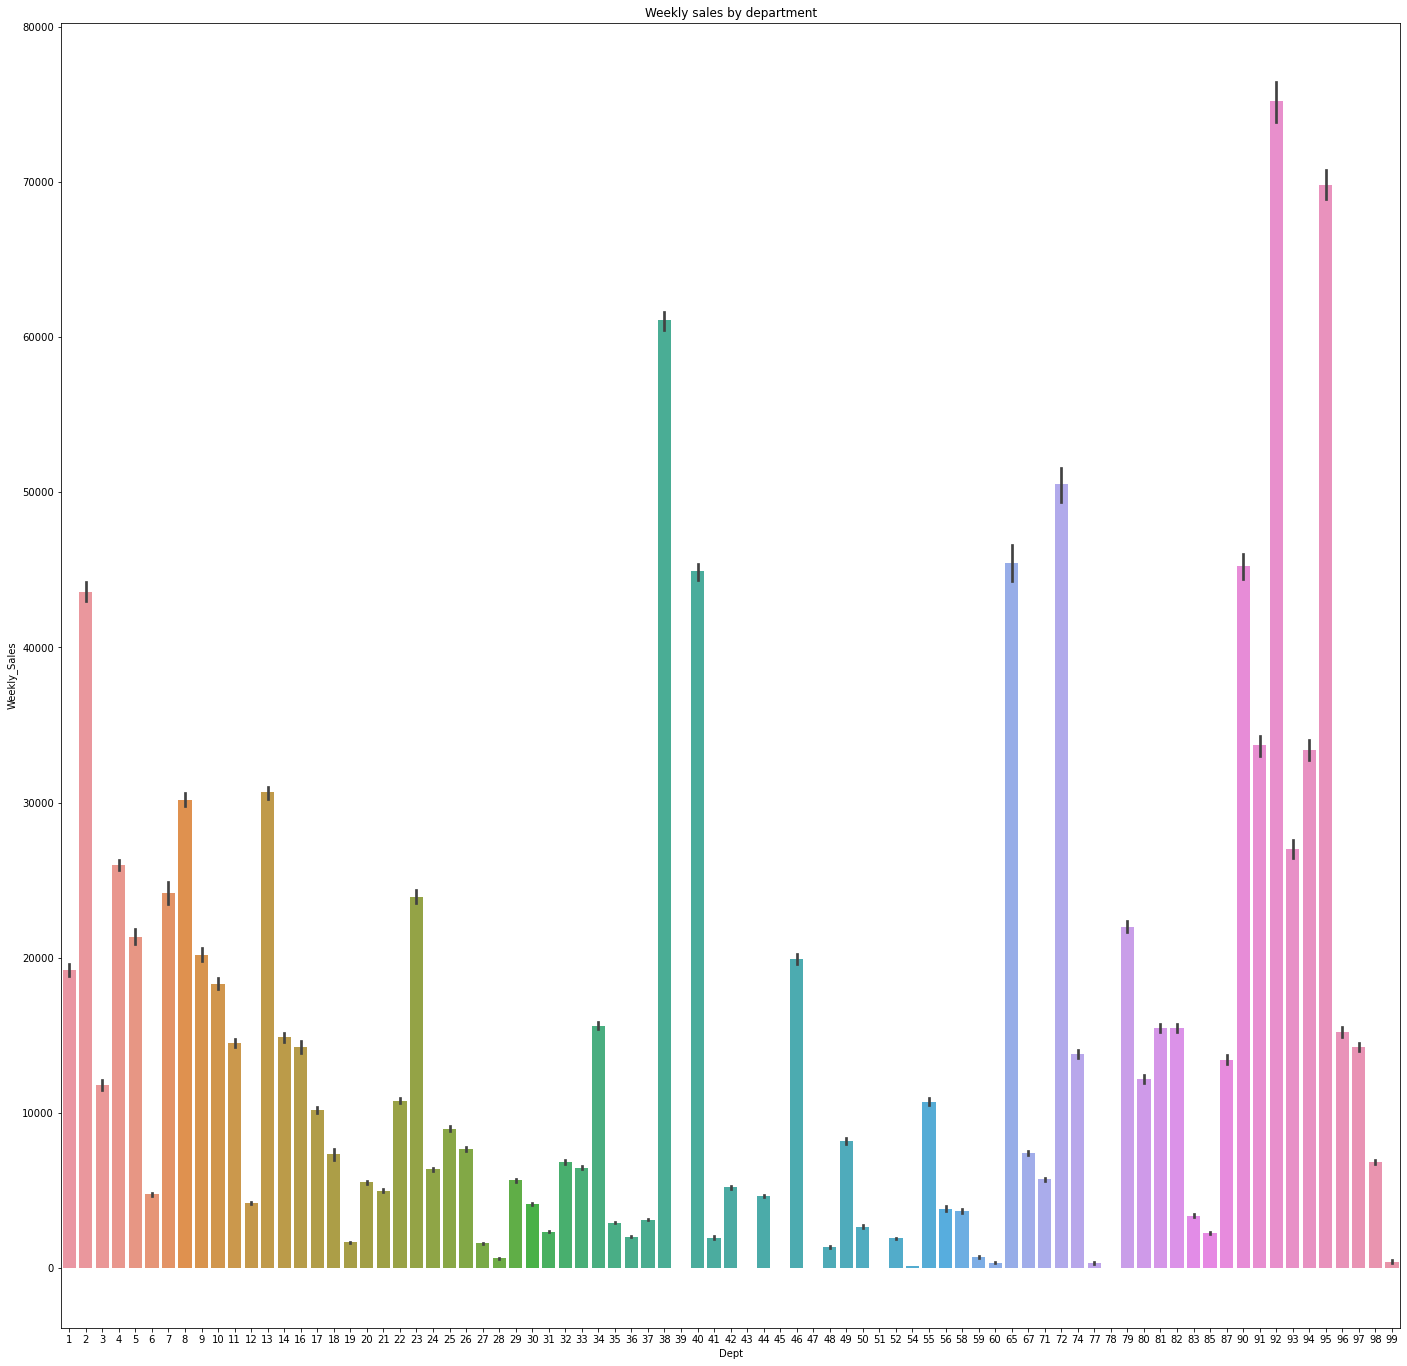

In [13]:
plt.figure(figsize=(24,24))
sns.barplot(x='Dept' , y='Weekly_Sales', data=df)
plt.title('Weekly sales by department')
plt.show()

In [254]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


In [7]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

C:\Users\32875\AppData\Local\Temp\ipykernel_25220\2890187965.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] =df['Date'].dt.week


In [8]:
df = df.fillna(0) # filling null's with 0

In [9]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df['Type'] = df['Type'].replace(type_group)

In [10]:
df = df.sort_values(by='Date', ascending=True) # sorting according to date

In [11]:
df_time = df.copy()
df = df.drop('Date', axis=1)

In [12]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
0,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,5,2,2010
330761,35,3,14612.19,False,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
330762,35,4,26323.15,False,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
330763,35,5,36414.63,False,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
330764,35,6,11437.81,False,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010


In [23]:
y = df['Weekly_Sales']
X = df.drop(columns=['Weekly_Sales'])
X_train = X[:int(0.7*(len(X)))] # taking train part
y_train = y[:int(0.7*(len(y)))] # taking train part
X_test = X[int(0.7*(len(X))):] # taking test part
y_test = y[int(0.7*(len(y))):] # taking test part

In [18]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [25]:
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)
pipe.fit(X_train, y_train)


# predictions on test set
y_pred_test_rf = pipe.predict(X_test)
y_test = np.array(y_test)
end_time = time.time()

In [28]:
execution_time = (end_time - start_time)
wmae_rf = wmae_test(y_test, y_pred_test_rf)
r2_rf = r2_score(y_test, y_pred_test_rf)
print("R2: {:.4f}".format(r2_rf))
print("WMAE: {:.4f}".format(wmae_rf))
print("Execution time: {:.2f} s".format(execution_time))

R2: 0.9521
WMAE: 2227.4108
Execution time: 152.20 s


In [31]:
start_time = time.time()
# Linear Regression model
lr = Pipeline([('scaler', scaler), ('regressor', LinearRegression())]) 
lr.fit(X_train, y_train)

# predictions on test set
y_pred_test_lr = lr.predict(X_test)
end_time = time.time()

In [32]:
execution_time = (end_time - start_time)
wmae_lr = wmae_test(y_test, y_pred_test_lr)
r2_lr = r2_score(y_test, y_pred_test_lr)
print("R2: {:.4f}".format(r2_lr))
print("WMAE: {:.4f}".format(wmae_lr))
print("Execution time: {:.2f} s".format(execution_time))

R2: 0.0877
WMAE: 14374.6075
Execution time: 0.82 s


In [33]:
start_time = time.time()
# Decision Tree
dt = Pipeline([('scaler', scaler), ('regressor', DecisionTreeRegressor())])
dt.fit(X_train, y_train)

# predictions on test set
y_pred_test_dt = dt.predict(X_test)
end_time = time.time()

In [35]:
execution_time = (end_time - start_time)
wmae_dt = wmae_test(y_test, y_pred_test_dt)
r2_dt = r2_score(y_test, y_pred_test_dt)
print("R2: {:.4f}".format(r2_dt))
print("WMAE: {:.4f}".format(wmae_dt))
print("Execution time: {:.2f} s".format(execution_time))

R2: 0.9121
WMAE: 2920.3356
Execution time: 2.84 s


In [36]:
start_time = time.time()
# Gradient Boosting Regressor
gbr = Pipeline([('scaler', scaler), ('regressor', GradientBoostingRegressor(n_estimators=100,random_state=42))])
gbr.fit(X_train, y_train)

# predictions on test set
y_pred_test_gbr = gbr.predict(X_test)
end_time = time.time()

In [37]:
execution_time = (end_time - start_time)
wmae_gbr = wmae_test(y_test, y_pred_test_gbr)
r2_gbr = r2_score(y_test, y_pred_test_gbr)
print("R2: {:.4f}".format(r2_gbr))
print("WMAE: {:.4f}".format(wmae_gbr))
print("Execution time: {:.2f} s".format(execution_time))

R2: 0.7706
WMAE: 6758.0935
Execution time: 26.31 s


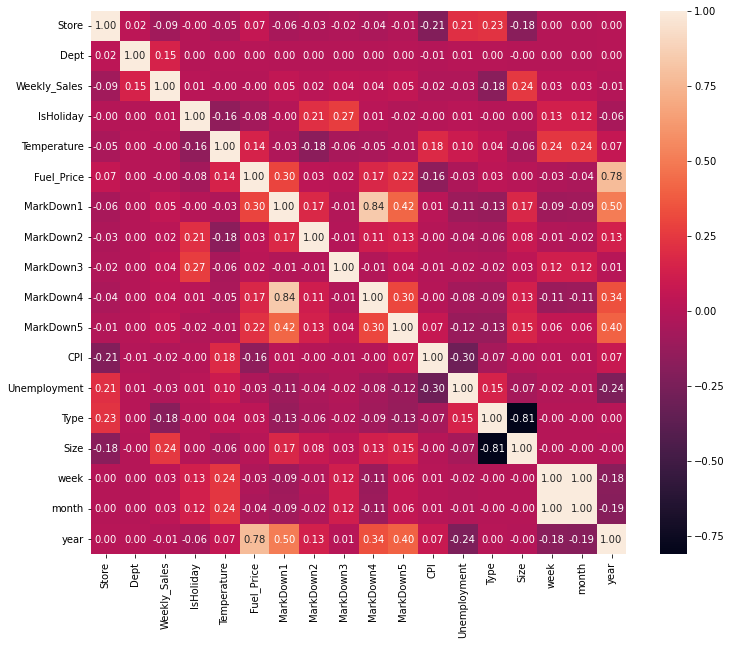

In [14]:
df_new = df.copy()
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr(), annot=True, fmt=".2f")  # To see the correlations
plt.show()

In [15]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment','month']
df_new.drop(drop_col, axis=1, inplace=True)

In [16]:
y_new = df_new['Weekly_Sales']
X_new = df_new.drop(columns=['Weekly_Sales'])
X_train_new = X_new[:int(0.7*(len(X_new)))] # taking train part
y_train_new = y_new[:int(0.7*(len(y_new)))] # taking train part
X_test_new = X_new[int(0.7*(len(X_new))):] # taking test part
y_test_new = y_new[int(0.7*(len(y_new))):] # taking test part

In [42]:
start_time = time.time()
pipe_new = make_pipeline(scaler,rf)
pipe_new.fit(X_train_new, y_train_new)

# predictions on test set
y_pred_test_new = pipe_new.predict(X_test_new)
y_test_new = np.array(y_test_new)
end_time = time.time()

In [43]:
execution_time = (end_time - start_time)
wmae_new = wmae_test(y_test_new, y_pred_test_new)
r2_new = r2_score(y_test_new, y_pred_test_new)
print("R2: {:.4f}".format(r2_new))
print("wMAE: {:.4f}".format(wmae_new))
print("Execution time: {:.2f} s".format(execution_time))

R2: 0.9741
wMAE: 1703.9402
Execution time: 79.09 s


In [50]:
# Tune Hyperparameter 
score_lt = []
estimators = [50, 100, 150, 200, 250]
for i in estimators:
    rf = RandomForestRegressor(n_estimators=i
                                ,random_state=42)
    pipe_tune = make_pipeline(scaler,rf)
    pipe_tune.fit(X_train_new, y_train_new)
    y_pred_test_tune = pipe_tune.predict(X_test_new)
    r2_tune = r2_score(y_test_new, y_pred_test_tune)
    score_lt.append(r2_tune)
score_max = max(score_lt)

In [53]:
score_lt

[0.973847841755471,
 0.9740598480867261,
 0.9740666417959656,
 0.9741621012232181,
 0.9742390170618223]

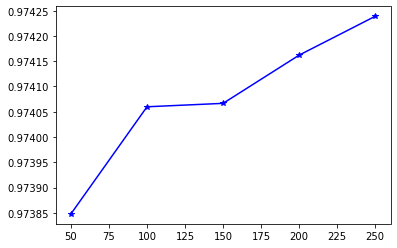

In [51]:
plt.plot(estimators, score_lt,'b-*')
plt.show()

In [52]:
print('Best R2 score:{}'.format(score_max),
      'n_estimators:{}'.format(estimators[score_lt.index(score_max)]))

Best R2 score:0.9742390170618223 n_estimators:250


In [48]:
depth = [10, 15, 20, 25]
score = []
for i in depth:
    rf_depth = RandomForestRegressor(n_estimators=250, max_depth=i, random_state=42)
    pipe_depth = make_pipeline(scaler, rf_depth)
    pipe_depth.fit(X_train_new, y_train_new)
    y_pred_test_depth = pipe_depth.predict(X_test_new)
    r2_depth = r2_score(y_test_new, y_pred_test_depth)
    score.append(r2_depth)
score_max = max(score)

In [49]:
score

[0.8970866232274588, 0.9648287531653236, 0.9738200849616183, 0.974248047389927]

In [21]:
start_time = time.time()
rf_tuned = RandomForestRegressor(n_estimators=250, max_depth=25, random_state=42)
pipe_tuned = make_pipeline(scaler, rf_tuned)
pipe_tuned.fit(X_train_new, y_train_new)


# predictions on test set
y_pred_test_tuned = pipe_tuned.predict(X_test_new)

end_time = time.time()

In [24]:
execution_time = (end_time - start_time)
wmae_tuned = wmae_test(y_test_new, y_pred_test_tuned)
r2_tuned = r2_score(y_test_new, y_pred_test_tuned)
print("R2: {:.4f}".format(r2_tuned))
print("WMAE: {:.4f}".format(wmae_tuned))
print("Execution time: {:.2f} s".format(execution_time))

R2: 0.9742
WMAE: 1697.4842
Execution time: 207.42 s


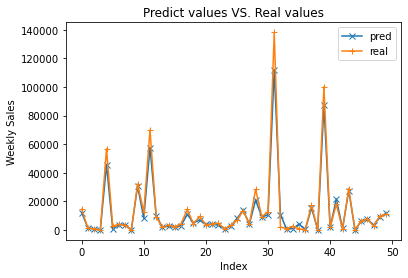

In [25]:
x = np.linspace(0,49,50)
plt.plot(x,y_pred_test_tuned[150:200],'x-', label="pred")
plt.plot(x,y_test_new[150:200], '+-', label="real")
plt.xlabel('Index')
plt.ylabel('Weekly Sales')
plt.title('Predict values VS. Real values')
plt.legend()
plt.show()

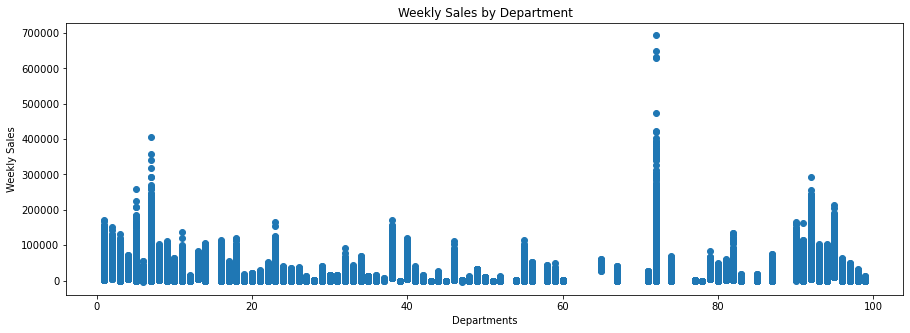

In [26]:
x = df_time['Dept']
y = df_time['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

In [27]:
df_time.head() # to see my data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,5,2,2010
330761,35,3,2010-02-05,14612.19,False,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
330762,35,4,2010-02-05,26323.15,False,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
330763,35,5,2010-02-05,36414.63,False,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010
330764,35,6,2010-02-05,11437.81,False,27.19,2.784,0.0,0.0,0.0,0.0,0.0,135.352461,9.262,2,103681,5,2,2010


In [28]:
df_time.set_index('Date', inplace=True) #seting date as index

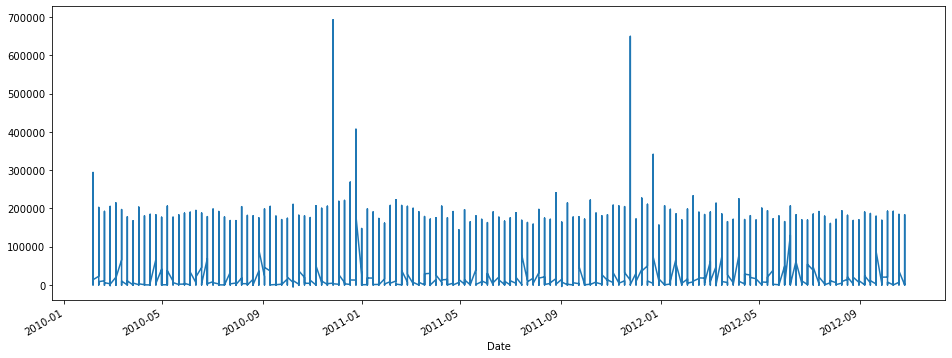

In [29]:
plt.figure(figsize=(16,6))
df_time['Weekly_Sales'].plot()
plt.show()

In [30]:
df_week = df_time.resample('W').mean() #resample data as weekly

In [31]:
df_week.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
Date,,,,,,,,,,,,,,,,,,
2010-02-07,22.038579,44.181726,16836.121997,0.0,33.277942,2.717869,0.0,0.0,0.0,0.0,0.0,167.398405,8.576731,1.587817,137430.535364,5.0,2.0,2010.0
2010-02-14,22.016915,44.377199,16352.056032,1.0,33.361810,2.696102,0.0,0.0,0.0,0.0,0.0,167.384138,8.567309,1.585927,137622.780785,6.0,2.0,2010.0
2010-02-21,22.038965,44.305341,16216.658979,0.0,37.038310,2.673666,0.0,0.0,0.0,0.0,0.0,167.338966,8.576351,1.587840,137278.637219,7.0,2.0,2010.0
2010-02-28,22.041681,44.107421,14899.549688,0.0,38.629563,2.685642,0.0,0.0,0.0,0.0,0.0,167.691019,8.561375,1.587936,137346.344629,8.0,2.0,2010.0
2010-03-07,22.043818,44.045516,15921.015727,0.0,42.373998,2.731816,0.0,0.0,0.0,0.0,0.0,167.727351,8.572689,1.585938,137576.841033,9.0,3.0,2010.0


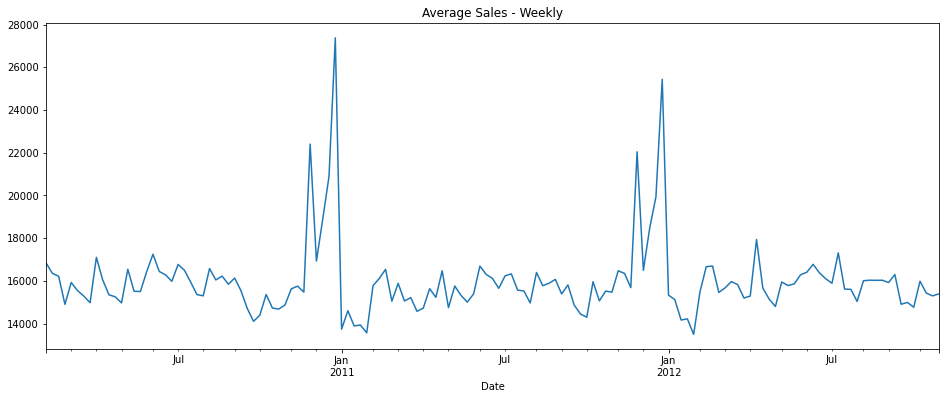

In [32]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [33]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 

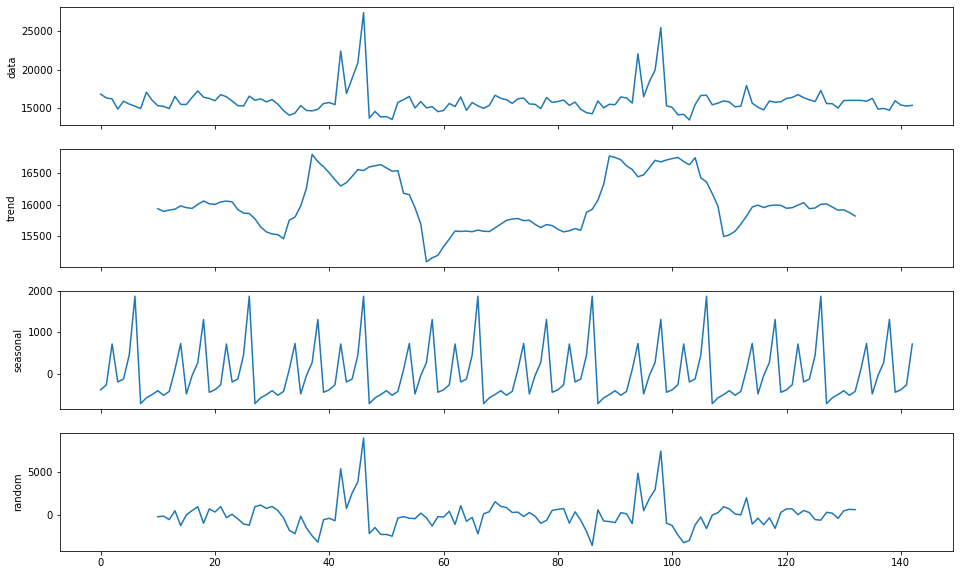

In [34]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

In [35]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [36]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff[int(0.7*(len(df_week_diff ))):]

In [37]:
test_data = df_week[int(0.7*(len(df_week_diff ))):]
def wmae_test(test, pred): # WMAE for test 
    weights = test_data['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [38]:
start_time = time.time()
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
end_time = time.time()

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1827.086, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.699, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.590, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.312, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1795.088, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.438, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.204, Tim

In [44]:
execution_time = (end_time - start_time)
wmae_arima = wmae_test(test_data_diff, y_pred)
print("WMAE: {:.4f}".format(wmae_arima))
print("Execution time: {:.2f} s".format(execution_time))

WMAE: 1076.2691
Execution time: 2.16 s


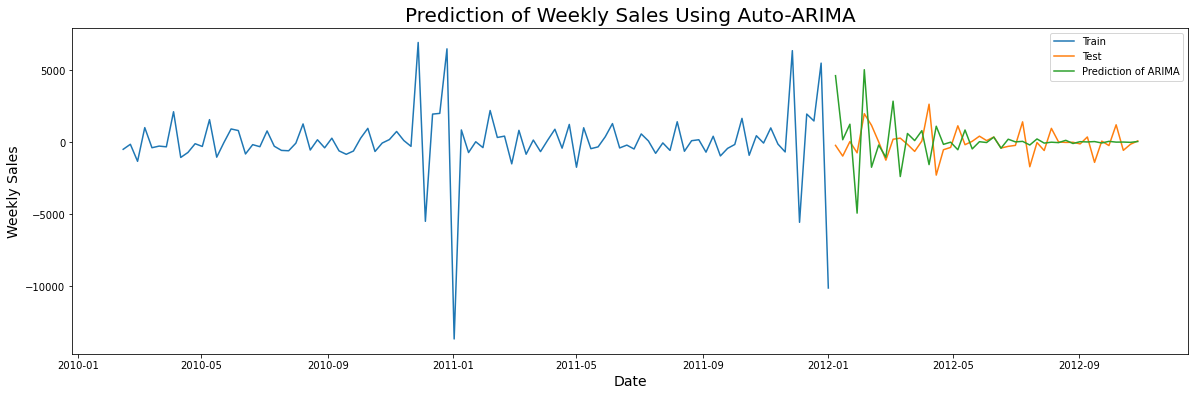

In [40]:
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

C:\Users\32875\AppData\Local\Temp\ipykernel_25220\1476779202.py:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
d:\anconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


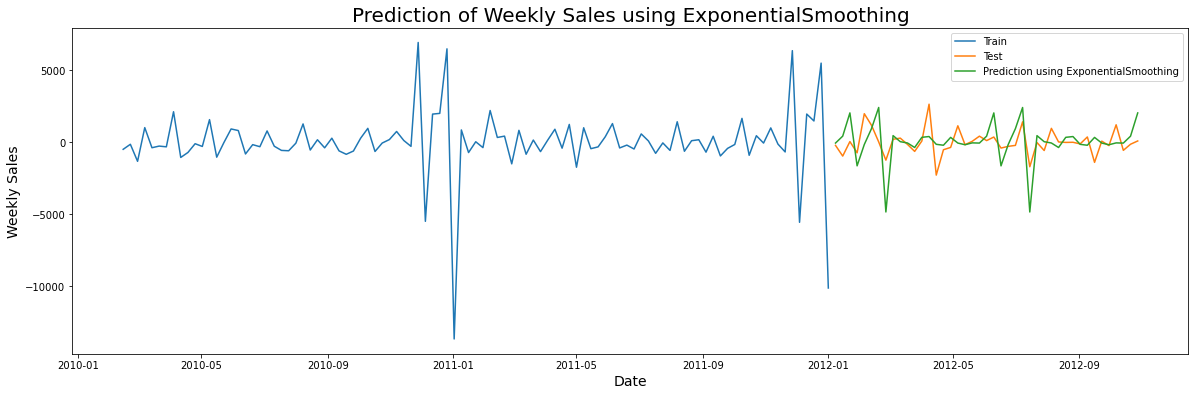

In [46]:
start_time = time.time()
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

end_time = time.time()
#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [47]:
execution_time = (end_time - start_time)
wmae_arima = wmae_test(test_data_diff, y_pred)
print("WMAE: {:.4f}".format(wmae_arima))
print("Execution time: {:.2f} s".format(execution_time))

WMAE: 767.5908
Execution time: 0.06 s
